# January flight prediction beginner
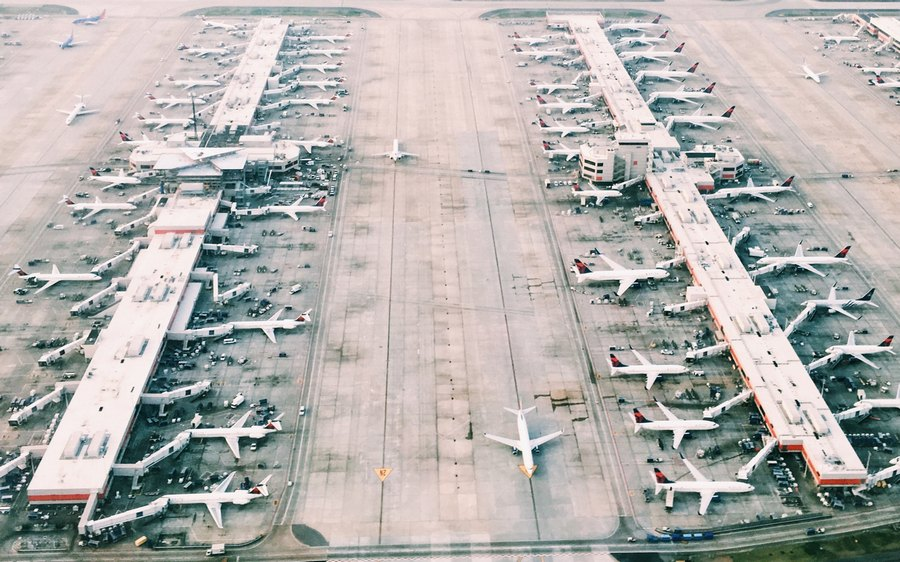

# IMPORTING LIBRARIES

In [ ]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
import numpy as np
from itertools import product
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from xgboost import XGBRegressor
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import time
import sys
import gc
import pickle
sys.version_info

# LOADING DATASET

In [ ]:
jan=pd.read_csv('../input/flight-delay-prediction/Jan_2019_ontime.csv')
jan1=pd.read_csv('../input/flight-delay-prediction/Jan_2020_ontime.csv')

In [ ]:
jan.tail()

In [ ]:
#DEP_TIME_BLK contains an invalid label 
#fix it to 0500-0559
jan.loc[jan['DEP_TIME_BLK'] == '0001-0559', 'DEP_TIME_BLK'] = '0500-0559'

# DATA VISUALISATION 

In [ ]:
#comparing arrivals and departures time frames

values = [jan['DEP_DEL15'].value_counts()[0],jan['DEP_DEL15'].value_counts()[1]]
labels = ["Delayed (<15 minutes)", "Delayed (>15 minutes)"]
colors = ['blue','red']
values_arr = [jan['ARR_DEL15'].value_counts()[0],jan['ARR_DEL15'].value_counts()[1]]

fig = make_subplots(1, 2, specs=[[{'type':'domain'}, {'type':'domain'}]],
                    subplot_titles=['Departures', 'Arrivals'])
fig.add_trace(go.Pie(labels=labels, values=values, pull=[0, 0.1],textinfo = 'label+percent'),1,1)
fig.add_trace(go.Pie(labels=labels, values=values_arr, pull=[0, 0.1],textinfo = 'label+percent'),1,2)
fig.update_traces( textinfo='value', textfont_size=14,
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))
fig.update_layout(uniformtext_minsize=4, uniformtext_mode='hide', title_text='Flights Delayed', title_x = 0.5, legend_title='<b>               Flights</b>',legend=dict(x=.45, y=0.6))

fig.show()

In [ ]:
#Barplot
# Set the width and height of the figure
plt.figure(figsize=(10,6))
# Add title
plt.title("Arrival Delays from different Airlines")
# Bar chart showing average arrival delay for Spirit Airlines flights by month
sns.barplot(x=jan.ORIGIN_AIRPORT_ID, y=jan['ARR_DEL15'])
# Add label for vertical axis
plt.ylabel("Arrival delay (in minutes)")

In [ ]:
#Barplot
# Set the width and height of the figure
plt.figure(figsize=(10,6))
# Add title
plt.title("Flight delay on week days")
# Bar chart showing average arrival delay for Spirit Airlines flights by month
sns.barplot(x=jan.DAY_OF_WEEK, y=jan['ARR_DEL15'])
# Add label for vertical axis
plt.ylabel("Arrival delay (in minutes)")

# DEALING WITH MISSING VALUES

In [ ]:
#drop flights with missing data
jan = jan[ (jan.CANCELLED != 1) & (jan.DEP_TIME.isna() == False) & (jan.ARR_TIME.isna() == False)]
len(jan.CANCELLED.isna()), len(jan.DEP_TIME.isna()), len(jan.ARR_TIME.isna()), len(jan)

# drop when target is NAN
jan = jan[ (jan.ARR_DEL15.isna() == False)]

# DROPING UNNECESSARY COLUMNS 

In [ ]:
cols=['Unnamed: 21','OP_CARRIER_AIRLINE_ID','OP_CARRIER','DIVERTED','CANCELLED','ORIGIN','TAIL_NUM','OP_CARRIER_FL_NUM','ORIGIN_AIRPORT_SEQ_ID','DEST_AIRPORT_SEQ_ID','DEST','DAY_OF_MONTH','OP_UNIQUE_CARRIER']
jan=jan.drop(cols,axis=1)

# CONVERTING DATA VALUES INTO MORE USEFUL FORM 

In [ ]:
def get_day_category(day_of_week):
    if day_of_week <= 5:
        return 0 #'for working day'
    elif day_of_week > 5:
        return 1 #'for weekend'
    
jan.DAY_OF_WEEK = jan.DAY_OF_WEEK.apply(get_day_category)
jan.rename(columns={'DAY_OF_WEEK':'type_of_day'})

In [ ]:
jan['origin_day_avg'] = jan.groupby(['ORIGIN_AIRPORT_ID','DAY_OF_WEEK'])['DEP_TIME'].transform('mean').astype(np.float16)
jan['dest_day_avg'] = jan.groupby(['DEST_AIRPORT_ID','DAY_OF_WEEK'])['ARR_TIME'].transform('mean').astype(np.float16)

In [ ]:
#replace missing target values 
def new_arrival_delay(dep_delay, arr_delay):
    if np.isnan(arr_delay):
        return dep_delay
    else:
        return arr_delay

jan['ARR_DEL15'] = jan.apply(lambda row :new_arrival_delay(row['DEP_DEL15'],row['ARR_DEL15']), axis = 1)

In [ ]:
# CREATE ARR_TIME_BLK 

#generate block hours
blocks = []
for hour in range(0,24):
    hour_part = ('%02d' %(hour))
    blocks.append(hour_part + '00-' + hour_part + '59')
blocks

def arrival_time_blk(arr_time):
    arr_hour = str('%04d' %(arr_time))[:2]
    arr_block = None
    for block in blocks:
        #print (block,arr_hour)
        if block.startswith(arr_hour):
            arr_block = block
            break
    if arr_block == None and str(arr_time) == '2400.0':
        arr_block = '0000-0059'
        #print('Cannot find block for #' + str(arr_time) + '#: set block to #' + arr_block + '#')
    return arr_block

jan['ARR_TIME_BLK'] = jan.ARR_TIME.apply(arrival_time_blk)
# drop the no more useful ARR_TIME
jan.drop(['ARR_TIME'], inplace=True, axis=1)


# LABEL ENCODING OF CATEGORICAL DATA COLUMNS 

In [ ]:
# label encode ARR_TIME_BLK and DEP_TIME_BLK
le = LabelEncoder()
le.fit(blocks)
le.classes_
jan['ARR_TIME_BLK'] = le.transform(jan.ARR_TIME_BLK.values)
jan['DEP_TIME_BLK'] = le.transform(jan.DEP_TIME_BLK.values)

In [ ]:
#Before spliting data, SORT IT FIRST
jan= jan.reindex(sorted(jan.columns), axis=1)


In [ ]:
jan.info()

In [ ]:
#Remove DEP_TIME column 
jan= jan.drop(['DEP_TIME','DEP_DEL15'], axis=1)

# SPILT DATA FOR TRAINING AND TESTING 

In [ ]:
from sklearn.model_selection import train_test_split
Y = jan['ARR_DEL15'].values
X = jan.drop(['ARR_DEL15'], axis=1).values

X_train, X_valid, Y_train, Y_valid =  train_test_split(X,Y, test_size=0.2, random_state=1)

# MODEL TRAINING WITH XGBOOST

In [ ]:
ts = time.time()

model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="auc", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

time.time() - ts

In [ ]:
Y_preds=model.predict(X_valid)

# FEATURE IMPORTANCE

In [ ]:
plot_features(model,(16,9))